In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import missingno as mno
import sweetviz as sv

from sklearn.model_selection import train_test_split

# this ignores the depreciation warnings etc
import warnings
warnings.filterwarnings("ignore")

#from google.colab import drive
#drive.mount('/content/drive')

In [99]:
vehicle = pd.read_parquet('./Data/vehicle_data.parquet')
accident = pd.read_parquet('./Data/accident_data.parquet')
accident_full = pd.read_parquet('./Data/accident_data_time_series.parquet')

In [102]:
accident.dropna(subset=['Carriageway_Hazards', 'Road_Surface_Conditions', 'Did_Police_Officer_Attend_Scene_of_Accident', 'Road_Type', 'Special_Conditions_at_Site', 'Latitude', 'Longitude', 'Light_Conditions', 'Pedestrian_Crossing-Human_Control', 'Time', 'Urban_or_Rural_Area', 'Pedestrian_Crossing-Physical_Facilities'], inplace=True)
accident['Weather_Conditions'].replace(np.NaN, 'Unknown', inplace=True)
accident['1st_Road_Class'].replace(np.NaN, 'Unknown', inplace=True)
accident['1st_Road_Number'].replace(np.NaN, 'Unknown', inplace=True)
accident['2nd_Road_Class'].replace(np.NaN, 'Unknown', inplace=True)
accident['2nd_Road_Number'].replace(np.NaN, 'Unknown', inplace=True)
accident['LSOA_of_Accident_Location'].replace(np.NaN, 'Unknown', inplace=True)

accident_full['Speed_limit'].replace(0, np.NaN, inplace=True)
accident_full.dropna(subset=['Speed_limit', 'Carriageway_Hazards', 'Road_Surface_Conditions', 'Did_Police_Officer_Attend_Scene_of_Accident', 'Road_Type', 'Special_Conditions_at_Site', 'Latitude', 'Longitude', 'Light_Conditions', 'Pedestrian_Crossing-Human_Control', 'Time', 'Urban_or_Rural_Area', 'Pedestrian_Crossing-Physical_Facilities'], inplace=True)
accident_full['Weather_Conditions'].replace(np.NaN, 'Unknown', inplace=True)
accident_full['1st_Road_Class'].replace(np.NaN, 'Unknown', inplace=True)
accident_full['1st_Road_Number'].replace(np.NaN, 'Unknown', inplace=True)
accident_full['2nd_Road_Class'].replace(np.NaN, 'Unknown', inplace=True)
accident_full['2nd_Road_Number'].replace(np.NaN, 'Unknown', inplace=True)
accident_full['LSOA_of_Accident_Location'].replace(np.NaN, 'Unknown', inplace=True)

accident_full = accident_full[accident_full['Special_Conditions_at_Site'] != 'Data missing or out of range']
accident_full = accident_full[accident_full['Road_Type'] != 'Unknown']
accident_full = accident_full[accident_full['Road_Surface_Conditions'] != 'Data missing or out of range']
accident_full = accident_full[accident_full['Light_Conditions'] != 'Data missing or out of range']
accident_full = accident_full[accident_full['Carriageway_Hazards'] != 'Data missing or out of range']
accident_full['1st_Road_Class'] = accident_full['1st_Road_Class'].map({"Unclassified": "Unknown"}).fillna(accident_full["1st_Road_Class"])

In [55]:
for column in accident.columns:
    print(column + ' : ' + str(len(accident[column].unique())))
    if(len(accident[column].unique()) < 100):
        print(column + ' : ' + str(accident[column].unique()))
    print('\n')

Accident_Index : 663339


1st_Road_Class : 6
1st_Road_Class : ['B' 'C' 'Unknown' 'A' 'Motorway' 'A(M)']


1st_Road_Number : 6540


2nd_Road_Class : 7
2nd_Road_Class : ['C' 'Unknown' 'Unclassified' 'B' 'A' 'Motorway' 'A(M)']


2nd_Road_Number : 6934


Accident_Severity : 3
Accident_Severity : ['Slight' 'Serious' 'Fatal']


Carriageway_Hazards : 6
Carriageway_Hazards : ['None' 'Other object on road' 'Previous accident'
 'Any animal in carriageway (except ridden horse)' 'Vehicle load on road'
 'Pedestrian in carriageway - not injured']


Date : 2191


Day_of_Week : 7
Day_of_Week : ['Wednesday' 'Thursday' 'Monday' 'Saturday' 'Sunday' 'Tuesday' 'Friday']


Did_Police_Officer_Attend_Scene_of_Accident : 3
Did_Police_Officer_Attend_Scene_of_Accident : [1. 2. 3.]


Junction_Control : 7
Junction_Control : ['Auto traffic signal' 'Data missing or out of range'
 'Give way or uncontrolled' 'Stop sign' 'Authorised person'
 'Auto traffic sigl' 'Not at junction or within 20 metres']


Junction_Detail :

In [12]:
vehicle.dropna(subset=['Vehicle_Location.Restricted_Lane'], inplace=True) 
vehicle['make'].replace(np.NaN, 'Unknown', inplace=True)
vehicle['model'].replace(np.NaN, 'Unknown', inplace=True)
vehicle['Propulsion_Code'].replace(np.NaN, 'Unknown', inplace=True)
vehicle['Driver_IMD_Decile'].replace(np.NaN, 0, inplace=True)
vehicle['Age_of_Vehicle'].replace(np.NaN, -1, inplace=True)
vehicle['Engine_Capacity_.CC.'].replace(np.NaN, -1, inplace=True)

In [14]:
'''for column in vehicle.columns:
    print(column + ' : ' + str(len(vehicle[column].unique())))
    if(len(vehicle[column].unique()) < 100):
        print(column + ' : ' + str(vehicle[column].unique()))
    print('\n')'''

"for column in vehicle.columns:\n    print(column + ' : ' + str(len(vehicle[column].unique())))\n    if(len(vehicle[column].unique()) < 100):\n        print(column + ' : ' + str(vehicle[column].unique()))\n    print('\n')"

In [17]:
rtc = pd.merge(accident, vehicle, how='left', on='Accident_Index')
#rtc.info()
rtc.dropna(subset=['Age_Band_of_Driver'], inplace=True)
#rtc.info()

In [93]:
accident['Date'] = pd.to_datetime(accident['Date'], format='%d/%m/%Y')
accident['Month'] = accident['Date'].apply(lambda x:x.month)
accident['Time'] = pd.to_datetime(accident['Time'], format='%H:%M')
accident['Hour'] = accident['Time'].apply(lambda x:x.hour)
accident['Junction_Control'] = accident['Junction_Control'].map({"Auto traffic sigl": "Auto traffic signal"}).fillna(accident["Junction_Control"])
accident['Special_Conditions_at_Site'] = accident['Special_Conditions_at_Site'].map({'Auto traffic sigl - out': 'Auto traffic signal - out', 'Auto sigl part defective':'Auto signal part defective'}).fillna(accident["Special_Conditions_at_Site"])
prepped = accident[['1st_Road_Class', '2nd_Road_Class', 'Accident_Severity', 'Carriageway_Hazards', 'Month', 'Day_of_Week', 'Junction_Control', 'Junction_Detail', 'Latitude', 'Light_Conditions', 'Longitude', 'Number_of_Casualties', 'Number_of_Vehicles', 'Pedestrian_Crossing-Human_Control', 'Pedestrian_Crossing-Physical_Facilities', 'Road_Surface_Conditions', 'Road_Type', 'Special_Conditions_at_Site', 'Speed_limit', 'Hour', 'Urban_or_Rural_Area', 'Weather_Conditions', 'InScotland']]
prepped.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1037512 entries, 1 to 1048574
Data columns (total 23 columns):
 #   Column                                   Non-Null Count    Dtype  
---  ------                                   --------------    -----  
 0   1st_Road_Class                           1037512 non-null  object 
 1   2nd_Road_Class                           1037512 non-null  object 
 2   Accident_Severity                        1037512 non-null  object 
 3   Carriageway_Hazards                      1037512 non-null  object 
 4   Month                                    1037512 non-null  int64  
 5   Day_of_Week                              1037512 non-null  object 
 6   Junction_Control                         1037512 non-null  object 
 7   Junction_Detail                          1037512 non-null  object 
 8   Latitude                                 1037512 non-null  float64
 9   Light_Conditions                         1037512 non-null  object 
 10  Longitude         

In [76]:
for column in prepped.columns:
    print(column + ' : ' + str(len(prepped[column].unique())))
    if(len(prepped[column].unique()) < 100):
        print(column + ' : ' + str(prepped[column].unique()))
    print('\n')

1st_Road_Class : 6
1st_Road_Class : ['B' 'C' 'Unknown' 'A' 'Motorway' 'A(M)']


2nd_Road_Class : 7
2nd_Road_Class : ['C' 'Unknown' 'Unclassified' 'B' 'A' 'Motorway' 'A(M)']


Accident_Severity : 3
Accident_Severity : ['Slight' 'Serious' 'Fatal']


Carriageway_Hazards : 6
Carriageway_Hazards : ['None' 'Other object on road' 'Previous accident'
 'Any animal in carriageway (except ridden horse)' 'Vehicle load on road'
 'Pedestrian in carriageway - not injured']


Month : 12
Month : [ 1  2  3  4  5  6  7  8  9 10 11 12]


Day_of_Week : 7
Day_of_Week : ['Wednesday' 'Thursday' 'Monday' 'Saturday' 'Sunday' 'Tuesday' 'Friday']


Junction_Control : 6
Junction_Control : ['Auto traffic signal' 'Data missing or out of range'
 'Give way or uncontrolled' 'Stop sign' 'Authorised person'
 'Not at junction or within 20 metres']


Junction_Detail : 10
Junction_Detail : ['Crossroads' 'Not at junction or within 20 metres'
 'T or staggered junction' 'Mini-roundabout' 'Other junction'
 'More than 4 arms (no

In [103]:
accident_full['Date'] = pd.to_datetime(accident_full['Date'], format='%Y-%m-%d')
accident_full['Month'] = accident_full['Date'].apply(lambda x:x.month)
accident_full['Time'] = pd.to_datetime(accident_full['Time'], format='%H:%M')
accident_full['Hour'] = accident_full['Time'].apply(lambda x:x.hour)
accident_full['Junction_Control'] = accident_full['Junction_Control'].map({"Auto traffic sigl": "Auto traffic signal"}).fillna(accident_full["Junction_Control"])
accident_full['Special_Conditions_at_Site'] = accident_full['Special_Conditions_at_Site'].map({'Auto traffic sigl - out': 'Auto traffic signal - out', 'Auto sigl part defective':'Auto signal part defective'}).fillna(accident_full["Special_Conditions_at_Site"])
accident_full['Speed_limit'] = accident_full['Speed_limit'].astype(int)
accident_full['Weather_Conditions'] = accident_full['Weather_Conditions'].map({"Data missing or out of range": "Unknown"}).fillna(accident_full["Weather_Conditions"])

prepped_full = accident_full[['1st_Road_Class', '2nd_Road_Class', 'Accident_Severity', 'Carriageway_Hazards', 'Month', 'Day_of_Week', 'Junction_Control', 'Junction_Detail', 'Latitude', 'Light_Conditions', 'Longitude', 'Number_of_Casualties', 'Number_of_Vehicles', 'Pedestrian_Crossing-Human_Control', 'Pedestrian_Crossing-Physical_Facilities', 'Road_Surface_Conditions', 'Road_Type', 'Special_Conditions_at_Site', 'Speed_limit', 'Hour', 'Urban_or_Rural_Area', 'Weather_Conditions', 'InScotland', 'Year']]
prepped_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2025923 entries, 0 to 2047255
Data columns (total 24 columns):
 #   Column                                   Dtype  
---  ------                                   -----  
 0   1st_Road_Class                           object 
 1   2nd_Road_Class                           object 
 2   Accident_Severity                        object 
 3   Carriageway_Hazards                      object 
 4   Month                                    int64  
 5   Day_of_Week                              object 
 6   Junction_Control                         object 
 7   Junction_Detail                          object 
 8   Latitude                                 float64
 9   Light_Conditions                         object 
 10  Longitude                                float64
 11  Number_of_Casualties                     int64  
 12  Number_of_Vehicles                       int64  
 13  Pedestrian_Crossing-Human_Control        float64
 14  Pedestrian_Crossin

In [95]:
for column in prepped_full.columns:
    print(column + ' : ' + str(len(prepped_full[column].unique())))
    if(len(prepped_full[column].unique()) < 100):
        print(column + ' : ' + str(prepped_full[column].unique()))
    print('\n')

1st_Road_Class : 6
1st_Road_Class : ['A' 'B' 'C' 'Unclassified' 'Motorway' 'A(M)']


2nd_Road_Class : 7
2nd_Road_Class : ['Unknown' 'C' 'Unclassified' 'B' 'A' 'Motorway' 'A(M)']


Accident_Severity : 3
Accident_Severity : ['Serious' 'Slight' 'Fatal']


Carriageway_Hazards : 7
Carriageway_Hazards : ['None' 'Other object on road' 'Pedestrian in carriageway - not injured'
 'Vehicle load on road' 'Previous accident'
 'Any animal in carriageway (except ridden horse)'
 'Data missing or out of range']


Month : 12
Month : [ 1  2  3  4  5  6  7  8  9 10 11 12]


Day_of_Week : 7
Day_of_Week : ['Tuesday' 'Wednesday' 'Thursday' 'Friday' 'Monday' 'Saturday' 'Sunday']


Junction_Control : 6
Junction_Control : ['Data missing or out of range' 'Auto traffic signal'
 'Give way or uncontrolled' 'Stop sign' 'Authorised person'
 'Not at junction or within 20 metres']


Junction_Detail : 10
Junction_Detail : ['Not at junction or within 20 metres' 'Crossroads'
 'T or staggered junction' 'Mini-roundabout' 'O

In [105]:
encode = pd.get_dummies(prepped, columns = ['1st_Road_Class', '2nd_Road_Class', 'Carriageway_Hazards', 'Month', 'Day_of_Week', 'Junction_Control', 'Junction_Detail', 'Light_Conditions', 'Pedestrian_Crossing-Human_Control', 'Pedestrian_Crossing-Physical_Facilities', 'Road_Surface_Conditions', 'Road_Type', 'Special_Conditions_at_Site', 'Speed_limit', 'Hour', 'Urban_or_Rural_Area', 'Weather_Conditions', 'InScotland'])
encode_full = pd.get_dummies(prepped_full, columns = ['1st_Road_Class', '2nd_Road_Class', 'Carriageway_Hazards', 'Month', 'Day_of_Week', 'Junction_Control', 'Junction_Detail', 'Light_Conditions', 'Pedestrian_Crossing-Human_Control', 'Pedestrian_Crossing-Physical_Facilities', 'Road_Surface_Conditions', 'Road_Type', 'Special_Conditions_at_Site', 'Speed_limit', 'Hour', 'Urban_or_Rural_Area', 'Weather_Conditions', 'InScotland'])
encode_full = encode_full[encode_full['Year'] > 2010]

encode_full = encode_full.drop('Year', axis = 1)

encode.info()
encode_full.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1037512 entries, 1 to 1048574
Columns: 137 entries, Accident_Severity to InScotland_Yes
dtypes: float64(2), int64(2), object(1), uint8(132)
memory usage: 178.1+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 976415 entries, 1058570 to 2047255
Data columns (total 137 columns):
 #    Column                                                                 Dtype  
---   ------                                                                 -----  
 0    Accident_Severity                                                      object 
 1    Latitude                                                               float64
 2    Longitude                                                              float64
 3    Number_of_Casualties                                                   int64  
 4    Number_of_Vehicles                                                     int64  
 5    1st_Road_Class_A                                                  

In [106]:
from pandas.api.types import CategoricalDtype
cat_type = CategoricalDtype(categories=['Slight', 'Serious', 'Fatal'], ordered=True)
encode['Accident_Severity'] = encode['Accident_Severity'].astype(cat_type)
#encode['Accident_Severity'].info()
encode['Accident_Severity'] = encode['Accident_Severity'].cat.codes

encode_full['Accident_Severity'] = encode_full['Accident_Severity'].astype(cat_type)
#encode['Accident_Severity'].info()
encode_full['Accident_Severity'] = encode_full['Accident_Severity'].cat.codes

In [107]:
X = encode.drop('Accident_Severity', axis=1).copy()
y = encode[['Accident_Severity']].copy()

test_size = int(len(X) * .15)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = test_size, random_state = 22)

In [108]:
from time import time
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, confusion_matrix

classifiers = [
    DecisionTreeClassifier(class_weight='balanced'),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    LGBMClassifier(),
    XGBClassifier(objective='multi:softmax', n_estimators=10, seed = 22)    
    ]

In [ ]:
'''best_Accuracy = 0
best_model = ''
for model in classifiers:
    start = time()
    model.fit(X_train, y_train)
    train_time = time() - start
    start = time()
    y_pred = model.predict(X_test)
    predict_time = time()-start
    if accuracy_score(y_test, y_pred) > best_Accuracy:
        best_Accuracy = accuracy_score(y_test, y_pred)
        best_model = model
    print(model)
    print("\tTraining time: %0.3fs" % train_time)
    print("\tPrediction time: %0.3fs" % predict_time)
    print("\tAccuarcy Score:", accuracy_score(y_test, y_pred))
    sns.displot(y_pred)
    matrix = confusion_matrix(y_test, y_pred)
    cm_df = pd.DataFrame(matrix,
                     index = ['Slight', 'Serious', 'Fatal'], 
                     columns = ['Slight', 'Serious', 'Fatal'])
    #Plotting the confusion matrix
    plt.figure(figsize=(5,4))
    sns.heatmap(cm_df, annot=True, fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('Actal Values')
    plt.xlabel('Predicted Values')
    plt.show()
    print("\tPositive Predicitive Value - Slight: %0.2f" % (matrix[0][0]/(matrix[0][0] + matrix[1][0] + matrix[2][0])))
    print("\tPositive Predicitive Value - Serious: %0.2f" % (matrix[1][1]/(matrix[0][1] + matrix[1][1] + matrix[2][1])))
    print("\tPositive Predicitive Value - Fatal: %0.2f" % (matrix[2][2]/(matrix[0][2] + matrix[1][2] + matrix[2][2])))
    print()

print('Best Model: ', best_model)
print('Best Accuracy: ', best_Accuracy)'''

In [ ]:
rtc['Date'] = pd.to_datetime(rtc['Date'], format='%d/%m/%Y')
rtc['Month'] = rtc['Date'].apply(lambda x:x.month)
rtc['Time'] = pd.to_datetime(rtc['Time'], format='%H:%M')
rtc['Hour'] = rtc['Time'].apply(lambda x:x.hour)
rtc['Junction_Control'] = rtc['Junction_Control'].map({"Auto traffic sigl": "Auto traffic signal"}).fillna(rtc["Junction_Control"])
rtc['Special_Conditions_at_Site'] = rtc['Special_Conditions_at_Site'].map({'Auto traffic sigl - out': 'Auto traffic signal - out', 'Auto sigl part defective':'Auto signal part defective'}).fillna(rtc["Special_Conditions_at_Site"])
prepped_rtc = rtc[['1st_Road_Class', '2nd_Road_Class', 'Accident_Severity', 'Carriageway_Hazards', 'Month', 'Day_of_Week', 'Junction_Control', 'Junction_Detail', 'Latitude', 'Light_Conditions', 'Longitude', 'Number_of_Casualties', 'Number_of_Vehicles', 'Pedestrian_Crossing-Human_Control', 'Pedestrian_Crossing-Physical_Facilities', 'Road_Surface_Conditions', 'Road_Type', 'Special_Conditions_at_Site', 'Speed_limit', 'Hour', 'Urban_or_Rural_Area', 'Weather_Conditions', 'InScotland', 'Age_Band_of_Driver', 'Age_of_Vehicle', 'Driver_Home_Area_Type', 'Driver_IMD_Decile', 'Engine_Capacity_.CC.','Hit_Object_in_Carriageway', 'Hit_Object_off_Carriageway', 'Journey_Purpose_of_Driver', 'Junction_Location', 'make', 'Propulsion_Code', 'Sex_of_Driver', 'Skidding_and_Overturning', 'Towing_and_Articulation', 'Vehicle_Leaving_Carriageway', 'Vehicle_Location.Restricted_Lane', 'Vehicle_Manoeuvre', 'Vehicle_Reference', 'Vehicle_Type', 'Was_Vehicle_Left_Hand_Drive', 'X1st_Point_of_Impact']]

In [ ]:
encode_rtc = pd.get_dummies(prepped_rtc, columns = ['1st_Road_Class', '2nd_Road_Class', 'Carriageway_Hazards', 'Month', 'Day_of_Week', 'Junction_Control', 'Junction_Detail', 'Light_Conditions', 'Pedestrian_Crossing-Human_Control', 'Pedestrian_Crossing-Physical_Facilities', 'Road_Surface_Conditions', 'Road_Type', 'Special_Conditions_at_Site', 'Speed_limit', 'Hour', 'Urban_or_Rural_Area', 'Weather_Conditions', 'InScotland', 'Age_Band_of_Driver', 'Driver_Home_Area_Type', 'Hit_Object_in_Carriageway', 'Hit_Object_off_Carriageway', 'Journey_Purpose_of_Driver', 'Junction_Location', 'make', 'Propulsion_Code', 'Sex_of_Driver', 'Skidding_and_Overturning', 'Towing_and_Articulation', 'Vehicle_Leaving_Carriageway', 'Vehicle_Manoeuvre', 'Vehicle_Type', 'Was_Vehicle_Left_Hand_Drive', 'X1st_Point_of_Impact'])

In [ ]:
encode_rtc['Accident_Severity'] = encode_rtc['Accident_Severity'].astype(cat_type)
encode_rtc['Accident_Severity'] = encode_rtc['Accident_Severity'].cat.codes

In [ ]:
rtc_X = encode_rtc.drop('Accident_Severity', axis=1).copy()
rtc_y = encode_rtc[['Accident_Severity']].copy()

test_size_rtc = int(len(rtc_X) * .15)

rtc_X_train, rtc_X_test, rtc_y_train, rtc_y_test = train_test_split(rtc_X, rtc_y, test_size = test_size_rtc, random_state = 22)

In [ ]:
'''best_Accuracy_rtc = 0
best_model_rtc = ''
for model in classifiers:
    start = time()
    model.fit(rtc_X_train, rtc_y_train)
    train_time = time() - start
    start = time()
    rtc_y_pred = model.predict(rtc_X_test)
    predict_time = time()-start
    if accuracy_score(rtc_y_test, rtc_y_pred) > best_Accuracy_rtc:
        best_Accuracy_rtc = accuracy_score(rtc_y_test, rtc_y_pred)
        best_model_rtc = model
    print(model)
    print("\tTraining time: %0.3fs" % train_time)
    print("\tPrediction time: %0.3fs" % predict_time)
    print("\tAccuarcy Score:", accuracy_score(rtc_y_test, rtc_y_pred))
    sns.displot(rtc_y_pred)
    matrix = confusion_matrix(rtc_y_test, rtc_y_pred)
    cm_df = pd.DataFrame(matrix,
                     index = ['Slight', 'Serious', 'Fatal'], 
                     columns = ['Slight', 'Serious', 'Fatal'])
    #Plotting the confusion matrix
    plt.figure(figsize=(5,4))
    sns.heatmap(cm_df, annot=True, fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('Actal Values')
    plt.xlabel('Predicted Values')
    plt.show()
    print("\tPositive Predicitive Value - Slight: %0.2f" % (matrix[0][0]/(matrix[0][0] + matrix[1][0] + matrix[2][0])))
    print("\tPositive Predicitive Value - Serious: %0.2f" % (matrix[1][1]/(matrix[0][1] + matrix[1][1] + matrix[2][1])))
    print("\tPositive Predicitive Value - Fatal: %0.2f" % (matrix[2][2]/(matrix[0][2] + matrix[1][2] + matrix[2][2])))
    print()

print('Best Model: ', best_model)
print('Best Accuracy: ', best_Accuracy)

print('Best Model RTC: ', best_model_rtc)
print('Best Accuracy RTC: ', best_Accuracy_rtc)'''

In [28]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=22)
X_resampled, y_resampled = rus.fit_resample(X, y)
print(y_resampled.value_counts())

test_size = int(len(X_resampled) * .15)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size = test_size, random_state = 22)

Accident_Severity
0                    14431
1                    14431
2                    14431
dtype: int64


In [ ]:
best_Accuracy = 0
best_model = ''
for model in classifiers:
    start = time()
    model.fit(X_train, y_train)
    train_time = time() - start
    start = time()
    y_pred = model.predict(X_test)
    predict_time = time()-start
    if accuracy_score(y_test, y_pred) > best_Accuracy:
        best_Accuracy = accuracy_score(y_test, y_pred)
        best_model = model
    print(model)
    print("\tTraining time: %0.3fs" % train_time)
    print("\tPrediction time: %0.3fs" % predict_time)
    print("\tAccuarcy Score:", accuracy_score(y_test, y_pred))
    sns.displot(y_pred)
    matrix = confusion_matrix(y_test, y_pred)
    cm_df = pd.DataFrame(matrix,
                     index = ['Slight', 'Serious', 'Fatal'], 
                     columns = ['Slight', 'Serious', 'Fatal'])
    #Plotting the confusion matrix
    plt.figure(figsize=(5,4))
    sns.heatmap(cm_df, annot=True, fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('Actal Values')
    plt.xlabel('Predicted Values')
    plt.show()
    print("\tPositive Predicitive Value - Slight: %0.2f" % (matrix[0][0]/(matrix[0][0] + matrix[1][0] + matrix[2][0])))
    print("\tPositive Predicitive Value - Serious: %0.2f" % (matrix[1][1]/(matrix[0][1] + matrix[1][1] + matrix[2][1])))
    print("\tPositive Predicitive Value - Fatal: %0.2f" % (matrix[2][2]/(matrix[0][2] + matrix[1][2] + matrix[2][2])))
    print()

print('Best Model: ', best_model)
print('Best Accuracy: ', best_Accuracy)

In [109]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=22, n_jobs=-1)
X_smote, y_smote = smote.fit_resample(X, y)

test_size = int(len(X_smote) * .15)
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size = test_size, random_state = 22)

In [ ]:
best_Accuracy = 0
best_model = ''
for model in classifiers:
    start = time()
    model.fit(X_train, y_train)
    train_time = time() - start
    start = time()
    y_pred = model.predict(X_test)
    predict_time = time()-start
    if accuracy_score(y_test, y_pred) > best_Accuracy:
        best_Accuracy = accuracy_score(y_test, y_pred)
        best_model = model
    print(model)
    print("\tTraining time: %0.3fs" % train_time)
    print("\tPrediction time: %0.3fs" % predict_time)
    print("\tAccuarcy Score:", accuracy_score(y_test, y_pred))
    sns.displot(y_pred)
    matrix = confusion_matrix(y_test, y_pred)
    cm_df = pd.DataFrame(matrix,
                     index = ['Slight', 'Serious', 'Fatal'], 
                     columns = ['Slight', 'Serious', 'Fatal'])
    #Plotting the confusion matrix
    plt.figure(figsize=(5,4))
    sns.heatmap(cm_df, annot=True, fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('Actal Values')
    plt.xlabel('Predicted Values')
    plt.show()
    print("\tPositive Predicitive Value - Slight: %0.2f" % (matrix[0][0]/(matrix[0][0] + matrix[1][0] + matrix[2][0])))
    print("\tPositive Predicitive Value - Serious: %0.2f" % (matrix[1][1]/(matrix[0][1] + matrix[1][1] + matrix[2][1])))
    print("\tPositive Predicitive Value - Fatal: %0.2f" % (matrix[2][2]/(matrix[0][2] + matrix[1][2] + matrix[2][2])))
    print()

print('Best Model: ', best_model)
print('Best Accuracy: ', best_Accuracy)

In [ ]:
rtc_smote = SMOTE(random_state=22, n_jobs=-1)
rtc_X_smote, rtc_y_smote = rtc_smote.fit_resample(rtc_X, rtc_y)

test_size = int(len(rtc_X_smote) * .15)
rtc_X_train, rtc_X_test, rtc_y_train, rtc_y_test = train_test_split(rtc_X_smote, rtc_y_smote, test_size = test_size, random_state = 22)

In [ ]:
best_Accuracy_rtc = 0
best_model_rtc = ''
for model in classifiers:
    start = time()
    model.fit(rtc_X_train, rtc_y_train)
    train_time = time() - start
    start = time()
    rtc_y_pred = model.predict(rtc_X_test)
    predict_time = time()-start
    if accuracy_score(rtc_y_test, rtc_y_pred) > best_Accuracy_rtc:
        best_Accuracy_rtc = accuracy_score(rtc_y_test, rtc_y_pred)
        best_model_rtc = model
    print(model)
    print("\tTraining time: %0.3fs" % train_time)
    print("\tPrediction time: %0.3fs" % predict_time)
    print("\tAccuarcy Score:", accuracy_score(rtc_y_test, rtc_y_pred))
    sns.displot(rtc_y_pred)
    matrix = confusion_matrix(rtc_y_test, rtc_y_pred)
    cm_df = pd.DataFrame(matrix,
                     index = ['Slight', 'Serious', 'Fatal'], 
                     columns = ['Slight', 'Serious', 'Fatal'])
    #Plotting the confusion matrix
    plt.figure(figsize=(5,4))
    sns.heatmap(cm_df, annot=True, fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('Actal Values')
    plt.xlabel('Predicted Values')
    plt.show()
    print("\tPositive Predicitive Value - Slight: %0.2f" % (matrix[0][0]/(matrix[0][0] + matrix[1][0] + matrix[2][0])))
    print("\tPositive Predicitive Value - Serious: %0.2f" % (matrix[1][1]/(matrix[0][1] + matrix[1][1] + matrix[2][1])))
    print("\tPositive Predicitive Value - Fatal: %0.2f" % (matrix[2][2]/(matrix[0][2] + matrix[1][2] + matrix[2][2])))
    print()

print('Best Model: ', best_model)
print('Best Accuracy: ', best_Accuracy)

print('Best Model RTC: ', best_model_rtc)
print('Best Accuracy RTC: ', best_Accuracy_rtc)

RandomForestClassifier()
	Training time: 1028.828s
	Prediction time: 20.842s
	Accuarcy Score: 0.935830204720381


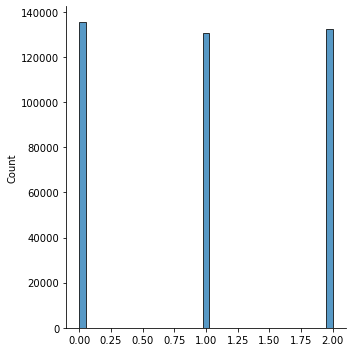

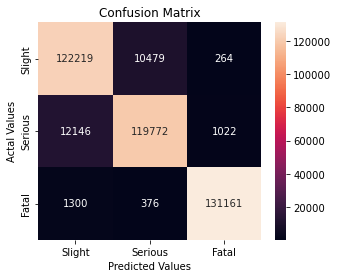

	Positive Predicitive Value - Slight: 0.90
	Positive Predicitive Value - Serious: 0.92
	Positive Predicitive Value - Fatal: 0.99

              precision    recall  f1-score   support

           0       0.90      0.92      0.91    132962
           1       0.92      0.90      0.91    132940
           2       0.99      0.99      0.99    132837

    accuracy                           0.94    398739
   macro avg       0.94      0.94      0.94    398739
weighted avg       0.94      0.94      0.94    398739



In [115]:
start = time()
tree2 = RandomForestClassifier()
tree2.fit(X_train, y_train)
train_time = time() - start
start = time()
y_pred = tree2.predict(X_test)
predict_time = time()-start
print(tree2)
print("\tTraining time: %0.3fs" % train_time)
print("\tPrediction time: %0.3fs" % predict_time)
print("\tAccuarcy Score:", accuracy_score(y_test, y_pred))
sns.displot(y_pred)
matrix = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(matrix,
    index = ['Slight', 'Serious', 'Fatal'], 
    columns = ['Slight', 'Serious', 'Fatal'])
#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()
print("\tPositive Predicitive Value - Slight: %0.2f" % (matrix[0][0]/(matrix[0][0] + matrix[1][0] + matrix[2][0])))
print("\tPositive Predicitive Value - Serious: %0.2f" % (matrix[1][1]/(matrix[0][1] + matrix[1][1] + matrix[2][1])))
print("\tPositive Predicitive Value - Fatal: %0.2f" % (matrix[2][2]/(matrix[0][2] + matrix[1][2] + matrix[2][2])))
print()
print(classification_report(y_test, y_pred))

In [112]:
X_full = encode_full.drop('Accident_Severity', axis=1).copy()
y_full = encode_full[['Accident_Severity']].copy()

	Accuarcy Score: 0.7947389173660789


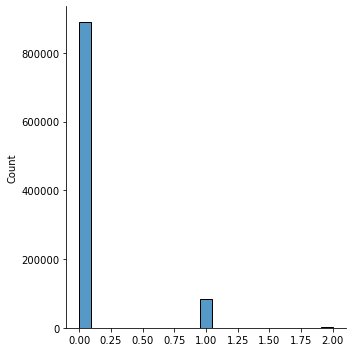

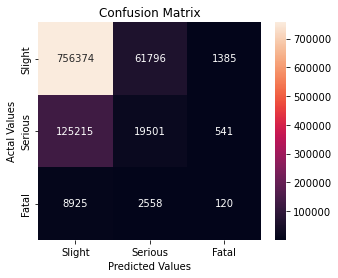

	Positive Predicitive Value - Slight: 0.85
	Positive Predicitive Value - Serious: 0.23
	Positive Predicitive Value - Fatal: 0.06

              precision    recall  f1-score   support

           0       0.85      0.92      0.88    819555
           1       0.23      0.13      0.17    145257
           2       0.06      0.01      0.02     11603

    accuracy                           0.79    976415
   macro avg       0.38      0.36      0.36    976415
weighted avg       0.75      0.79      0.77    976415



In [113]:
from sklearn.metrics import classification_report

y_pred = tree2.predict(X_full)
print("\tAccuarcy Score:", accuracy_score(y_full, y_pred))
sns.displot(y_pred)
matrix = confusion_matrix(y_full, y_pred)
cm_df = pd.DataFrame(matrix,
    index = ['Slight', 'Serious', 'Fatal'], 
    columns = ['Slight', 'Serious', 'Fatal'])
#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()
print("\tPositive Predicitive Value - Slight: %0.2f" % (matrix[0][0]/(matrix[0][0] + matrix[1][0] + matrix[2][0])))
print("\tPositive Predicitive Value - Serious: %0.2f" % (matrix[1][1]/(matrix[0][1] + matrix[1][1] + matrix[2][1])))
print("\tPositive Predicitive Value - Fatal: %0.2f" % (matrix[2][2]/(matrix[0][2] + matrix[1][2] + matrix[2][2])))
print()
print(classification_report(y_full, y_pred))